In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from atusfunclib import load_data
from activitylib import ACTINFO
import wlmetrics as wlm
import pickle
from datetime import date
from scipy.stats import gaussian_kde

In [6]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn import metrics
from sklearn.externals import joblib
from sklearn import base

In [7]:
from modellib import compute_mse, BaseResEnsembleEstimator, DataFrameSelector, EstimatorTransformer, ImputeNumber

In [8]:
# Import all csv data
data_import = load_data(loc="data", loc_clean="cleaned_data", loc_codes="code_tables")

In [9]:
# Unpack individual dataframes
df, dfactcodes, dfeducodes, dfinccodes, dfagecodes, \
dfempcodes, dfindcodes, dfraccodes, dfloccodes, dfwhocodes, \
dfdemocodes = data_import

In [10]:
# Convert category columns to float
df['TEAGE_CAT'] = df['TEAGE_CAT'].astype(float)
df['TRERNWA_CAT'] = df['TRERNWA_CAT'].astype(float)

In [11]:
# Convert category columns to float
df['TEAGE_CAT'] = df['TEAGE_CAT'].astype(float)
df['TRERNWA_CAT'] = df['TRERNWA_CAT'].astype(float)

In [12]:
# Split by weekday and weekend/holiday
df_wehol = df[(df['TRHOLIDAY'] == 1) | (df['TRWEEKEND'] == 1)]
df_weday = df[(df['TRHOLIDAY'] == 0) & (df['TRWEEKEND'] == 0)]

In [13]:
del df

In [14]:
# Weights for ratio calculation
weights_p = np.array([0.1, 0.2, 1.0, 0.6, 0.6, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.2])
weights_n_occ = np.array([0.0, 1.0, 0.8, 1.0])
weights_n_hom = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8])

In [15]:
# Calculate metrics (i.e. y data)
df_weday_y = pd.DataFrame()
df_wehol_y = pd.DataFrame()

# Weekday
df_weday_y['metric1'] = wlm.w_l_balance_weighted_ratio(df_weday,
                                                       ACTINFO['positiveWL'], ACTINFO['negoccWL'],
                                                       weights_p, weights_n_occ)
df_weday_y['metric2'] = wlm.w_l_balance_weighted_ratio(df_weday,
                                                       ACTINFO['positiveWL'], ACTINFO['neghomeWL'],
                                                       weights_p, weights_n_hom)

df_weday_y['metric3'] = wlm.w_l_balance_personalcare(df_weday)
df_weday_y['metric4'] = wlm.w_l_balance_leisuresocial(df_weday)

df_weday_y['metric5'] = wlm.w_l_balance_workday(df_weday, workid='0501', hours=9)
df_weday_y['metric6'] = wlm.w_l_balance_housework(df_weday, hours=4)

# Weekend/holiday
df_wehol_y['metric1'] = wlm.w_l_balance_weighted_ratio(df_wehol,
                                                       ACTINFO['positiveWL'], ACTINFO['negoccWL'],
                                                       weights_p, weights_n_occ)
df_wehol_y['metric2'] = wlm.w_l_balance_weighted_ratio(df_wehol,
                                                       ACTINFO['positiveWL'], ACTINFO['neghomeWL'],
                                                       weights_p, weights_n_hom)

df_wehol_y['metric3'] = wlm.w_l_balance_personalcare(df_wehol)
df_wehol_y['metric4'] = wlm.w_l_balance_leisuresocial(df_wehol)

df_wehol_y['metric5'] = wlm.w_l_balance_workday(df_wehol, workid='0501', hours=9)
df_wehol_y['metric6'] = wlm.w_l_balance_housework(df_wehol, hours=4)

In [16]:
df_weday_y.head()

,metric1,metric2,metric3,metric4,metric5,metric6
0,0.713028,0.682509,0.031250,0.364583,False,False
3,0.589085,0.479548,0.041667,0.184028,False,True
4,0.405106,0.491040,0.115972,0.083333,False,False
5,0.649472,0.471952,0.069444,0.211806,False,True
6,0.365951,0.427464,0.082639,0.001389,False,False


In [17]:
df_wehol_y.head()

,metric1,metric2,metric3,metric4,metric5,metric6
1,0.759298,0.734520,0.104167,0.409722,False,False
2,0.665614,0.570107,0.107639,0.236111,False,True
8,0.589298,0.448221,0.100694,0.083333,False,True
10,0.308947,0.558185,0.052083,0.083333,True,False
11,0.603684,0.558897,0.076389,0.121528,False,False


In [18]:
# Features list
features = ['TEAGE', 'TESEX', 'GEMETSTA', 'GESTFIPS',
            'TELFS', 'TRDPFTPT',
            'TRSPPRES', 'TESPEMPNOT',
            'TESCHENR', 'PEEDUCA',
            'PTDTRACE',
            'TRCHILDNUM', 'TRNUMHOU',
            'TRDTOCC1', 'TEIO1COW', 'TRERNWA']

catfeatures = ['GEMETSTA', 'GESTFIPS',
               'TELFS', 'TRDPFTPT',
               'TRSPPRES', 'TESPEMPNOT',
               'TESCHENR',
               'PTDTRACE',
               'TRDTOCC1', 'TEIO1COW']

In [19]:
# Features matrix (i.e. X data)
df_weday_X = df_weday[features]
df_wehol_X = df_wehol[features]

In [20]:
# Split train-test indices
rs = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

train_wd, test_wd = rs.split(df_weday).next()
train_wh, test_wh = rs.split(df_wehol).next()

In [21]:
del df_weday
del df_wehol

## Set training and test data

In [73]:
m = 'metric5'
dt = 'weday'

if dt == 'weday':
    y = df_weday_y[m].iloc[train_wd].as_matrix()
    X = df_weday_X.iloc[train_wd]

    y_test = df_weday_y[m].iloc[test_wd].as_matrix()
    X_test = df_weday_X.iloc[test_wd]
else:
    y = df_wehol_y[m].iloc[train_wd].as_matrix()
    X = df_wehol_X.iloc[train_wd]

    y_test = df_wehol_y[m].iloc[test_wd].as_matrix()
    X_test = df_wehol_X.iloc[test_wd]

In [93]:
# Subsample False features for training ?
print 1.0 - y.sum() / float(y.shape[0])

0.846796286938


## Build estimator for age, education, weekly income, child number, household number

In [42]:
# Polynominal features for age
agetrans = Pipeline([
    ('featse1', DataFrameSelector(feature_names=['TEAGE'], dtype=float)),
    ('polyno1', PolynomialFeatures(degree=3, include_bias=True)),
])

# Education level feature
edutrans = Pipeline([
    ('featse2', DataFrameSelector(feature_names=['PEEDUCA'], dtype=float)),
    ('impute2', Imputer(missing_values='NaN', strategy='median', axis=0)),
])

# Weekly earnings feature
weatrans = Pipeline([
    ('featse3', DataFrameSelector(feature_names=['TRERNWA'], dtype=float)),
    ('impute3', ImputeNumber()),
])

# Number of children/household features
lintrans = Pipeline([
    ('featse4', DataFrameSelector(feature_names=['TRCHILDNUM', 'TRNUMHOU'], dtype=float)),
    ('impute4', ImputeNumber()),
])

est = Pipeline([
    ('union01', FeatureUnion([
        ('agetran', agetrans),
        ('edutran', edutrans),
        ('weatran', weatrans),
        ('lintran', lintrans),
    ])),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=1.2, random_state=42))
])

In [24]:
# Grid search CV
tc = [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2]
gridsearch1 = GridSearchCV(est,
                          {'logreg__C': tc
                          },
                          cv=7,
                          n_jobs=-2,
                          scoring='accuracy',
                          verbose=True)

In [25]:
gridsearch1.fit(X, y)

Fitting 7 folds for each of 13 candidates, totalling 91 fits


[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-2)]: Done  91 out of  91 | elapsed:   22.6s finished


GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('agetran', Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'float'>, feature_names=['TEAGE'], ntn=False)), ('polyno1', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False))])), ('edutra...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'logreg__C': [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [26]:
gridsearch1.best_params_

{'logreg__C': 1.2}

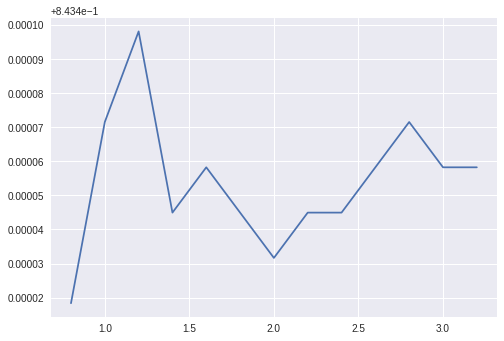

In [27]:
# Graphs
plt.plot(tc, gridsearch1.cv_results_['mean_test_score']);

### Fitting using the best parameters on training set for a specific metric

In [43]:
est.fit(X, y)

Pipeline(memory=None,
     steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('agetran', Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'float'>, feature_names=['TEAGE'], ntn=False)), ('polyno1', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False))])), ('edutra...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [44]:
est.score(X, y)

0.84359124398223262

In [45]:
metrics.accuracy_score(y_test, est.predict(X_test))

0.8482345900658288

In [70]:
est.predict(X.head(100))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True, False], dtype=bool)

In [47]:
y[:100]

array([False, False,  True, False,  True, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False,  True,  True, False,  True,
        True, False, False, False, False,  True, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False,  True, False], dtype=bool)

## Build estimator for all categorical features

In [52]:
# Use one-hot-encoding followed by truncated SVD to reduce feature count
est_cat = Pipeline([
    ('featse1', DataFrameSelector(feature_names=catfeatures, dtype=np.int64, ntn=True)),
    ('encode1', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('sscaler', StandardScaler()),
    ('trunsvd', TruncatedSVD(n_components=100, random_state=42)),
    ('rfclass', RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42))
])

In [38]:
# Grid search CV
gridsearch_cat = GridSearchCV(est_cat,
                              {'rfclass__max_depth': [8, 10, 12, 15]
                              },
                              cv=3,
                              n_jobs=-2,
                              scoring='accuracy',
                              verbose=True)

In [39]:
gridsearch_cat.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'numpy.int64'>,
         feature_names=['GEMETSTA', 'GESTFIPS', 'TELFS', 'TRDPFTPT', 'TRSPPRES', 'TESPEMPNOT', 'TESCHENR', 'PTDTRACE', 'TRDTOCC1', 'TEIO1COW'],
         ntn=True)), ('encode1', OneHotEncoder(categorical_features='all', dtype=<type 'num...stimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'rfclass__max_depth': [8, 10, 12, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [40]:
gridsearch_cat.best_params_

{'rfclass__max_depth': 8}

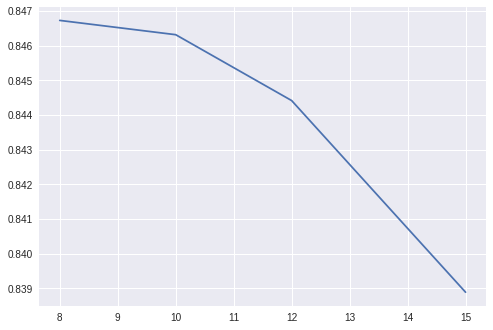

In [51]:
# Graphs
plt.plot([8, 10, 12, 15], gridsearch_cat.cv_results_['mean_test_score']);

### Fitting using the best parameters on training set for a specific metric

In [53]:
est_cat.fit(X, y)

Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'numpy.int64'>,
         feature_names=['GEMETSTA', 'GESTFIPS', 'TELFS', 'TRDPFTPT', 'TRSPPRES', 'TESPEMPNOT', 'TESCHENR', 'PTDTRACE', 'TRDTOCC1', 'TEIO1COW'],
         ntn=True)), ('encode1', OneHotEncoder(categorical_features='all', dtype=<type 'num...stimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [54]:
est_cat.score(X, y)

0.8471287602734261

In [55]:
metrics.accuracy_score(y_test, est_cat.predict(X_test))

0.84955116696588873

In [66]:
est_cat.predict(X.head(100))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False], dtype=bool)

In [67]:
y[:100]

array([False, False,  True, False,  True, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False,  True,  True, False,  True,
        True, False, False, False, False,  True, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False,  True, False], dtype=bool)

## Combined model that uses both continuous and categorical models

In [58]:
# Polynominal features for age
agetrans = Pipeline([
    ('featse1', DataFrameSelector(feature_names=['TEAGE'], dtype=float)),
    ('polyno1', PolynomialFeatures(degree=3, include_bias=True))
])

# Education level feature
edutrans = Pipeline([
    ('featse2', DataFrameSelector(feature_names=['PEEDUCA'], dtype=float)),
    ('impute2', Imputer(missing_values='NaN', strategy='median', axis=0))
])

# Weekly earnings feature
weatrans = Pipeline([
    ('featse3', DataFrameSelector(feature_names=['TRERNWA'], dtype=float)),
    ('impute3', ImputeNumber())
])

# Number of children/household features
lintrans = Pipeline([
    ('featse4', DataFrameSelector(feature_names=['TRCHILDNUM', 'TRNUMHOU'], dtype=float)),
    ('impute4', ImputeNumber())
])

# Categorical features
cattrans = Pipeline([
    ('featse5', DataFrameSelector(feature_names=catfeatures, dtype=np.int64, ntn=True)),
    ('encode5', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

est_full = Pipeline([
    ('union01', FeatureUnion([
        ('agetran', agetrans),
        ('edutran', edutrans),
        ('weatran', weatrans),
        ('lintran', lintrans),
        ('cattran', cattrans)
    ])),
    ('scaler', StandardScaler()),
    ('trunsvd', TruncatedSVD(n_components=80, random_state=42)),
    ('rfclass', RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42))
])

In [60]:
est_full.fit(X, y)

Pipeline(memory=None,
     steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('agetran', Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'float'>, feature_names=['TEAGE'], ntn=False)), ('polyno1', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False))])), ('edutra...stimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [63]:
est_full.score(X, y)

0.84692927627204295

In [64]:
metrics.accuracy_score(y_test, est_full.predict(X_test))

0.84967085577498502

In [72]:
est_full.predict(X.head(100))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False], dtype=bool)